## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

# Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [221]:
# # https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# input_layer = Input(shape=(n,))
# embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
# flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
import pandas as pd
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, Concatenate, Dropout, LSTM
from tensorflow.keras.models import Model
# from tensorflow.python.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
data = pd.read_csv('preprocessed_data_26.csv')
print('data shape:', data.shape)
# data.head(2)

data shape: (109248, 12)


### Checking weather data is balanc or not

In [4]:
from collections import Counter
d1 = dict(Counter(data['project_is_approved']))
print(d1)
print('class 0: {} %'.format(d1[0]*100/sum(d1.values())))
print('class 1: {} %'.format(d1[1]*100/sum(d1.values())))

# Observation:- since data is imbalance so we need to balance it.

{0: 16542, 1: 92706}
class 0: 15.141695957820739 %
class 1: 84.85830404217926 %


In [5]:
# seperating class 0 data
data0 = data[data['project_is_approved']==0]
data0.shape

(16542, 12)

#### Upsampling

In [6]:
# merging class 0 and class 1 data
data01 = pd.concat([data0, data, data0], axis=0, ignore_index=True)
print(data01.shape)

(142332, 12)


In [7]:
d1 = dict(Counter(data01['project_is_approved']))
print(d1)
print('class 0: {} %'.format(d1[0]*100/sum(d1.values())))
print('class 1: {} %'.format(d1[1]*100/sum(d1.values())))

# Observation:- now the data is balanced

{0: 49626, 1: 92706}
class 0: 34.86636877160442 %
class 1: 65.13363122839559 %


In [8]:
data = data01
# Mising all text data
data['text'] = data['project_title']+' '+data['essay']

### Seperating Features and Target data

In [9]:
y = data['project_is_approved']
X = data.drop(['project_is_approved'], axis=1)
print(X.shape, y.shape)

(142332, 12) (142332,)


### Splitting the data into Train, Test and CV

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, random_state=50)

print('train shape: ', X_train.shape, y_train.shape)
print('test shape: ', X_test.shape, y_test.shape)
print('cv shape: ', X_cv.shape, y_cv.shape)

train shape:  (85398, 12) (85398,)
test shape:  (28467, 12) (28467,)
cv shape:  (28467, 12) (28467,)


In [11]:
set_sproject_subject_subcategories = \
set(X_test['project_subject_subcategories']).union(set(X_cv['project_subject_subcategories']) )-set(X_train['project_subject_subcategories'])
set_sproject_subject_subcategories

# these are the extra values in feature 'project_subject_subcategories' which are in either X_test or X_cv but not in X_train,
# removing the row from X_tes and X_cv, which contain these values to get rid of "y contains previously unseen labels"

{'charactereducation_nutritioneducation',
 'civics_government_health_wellness',
 'civics_government_nutritioneducation',
 'civics_government_parentinvolvement',
 'civics_government_teamsports',
 'college_careerprep_warmth_care_hunger',
 'communityservice_music',
 'communityservice_performingarts',
 'economics_literature_writing',
 'economics_music',
 'esl_nutritioneducation',
 'financialliteracy_health_wellness',
 'financialliteracy_performingarts',
 'gym_fitness_parentinvolvement',
 'history_geography_warmth_care_hunger',
 'literature_writing_nutritioneducation',
 'nutritioneducation_socialsciences',
 'parentinvolvement_teamsports',
 'parentinvolvement_warmth_care_hunger'}

In [12]:
for index in X_test.index:
    if X_test.loc[index, 'project_subject_subcategories'] in set_sproject_subject_subcategories:
        X_test.drop(index, inplace=True)
        y_test.drop(index, inplace=True)
        
print(X_test.shape)
print(y_test.shape)

C:\Users\Nehal\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(28454, 12)
(28454,)


In [13]:
for index in X_cv.index:
    if X_cv.loc[index, 'project_subject_subcategories'] in set_sproject_subject_subcategories:
        X_cv.drop(index, inplace=True)
        y_cv.drop(index, inplace=True)
        
print(X_cv.shape)
print(y_cv.shape)

(28449, 12)
(28449,)


In [14]:
set_sproject_subject_subcategories = \
set(X_test['project_subject_subcategories']).union(set(X_cv['project_subject_subcategories']) )-set(X_train['project_subject_subcategories'])
set_sproject_subject_subcategories

set()

### Converting target data i.e. 'project_is_approved' into OneHot, because of categorical_cross_entropy

In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)
print('train shape: ', X_train.shape, y_train.shape)
print('test shape: ', X_test.shape, y_test.shape)
print('cv shape: ', X_cv.shape, y_cv.shape)

train shape:  (85398, 12) (85398, 2)
test shape:  (28454, 12) (28454, 2)
cv shape:  (28449, 12) (28449, 2)


#### removing all the categorical data from test and cv data which are not in training data to get rid of "y contains unknown features"

### Converting text data (essay, project_title) to Numerical data by text_to_sequence and then padding and then embedding

In [16]:
# Tokenize our training data
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(X_train['text'])

# Get our training data word index
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
print('vocab size:', vocab_size)
# print('word index: ', word_index)

vocab size: 59274


In [17]:
# Encode train, test and cv data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train['text'])
test_sequences = tokenizer.texts_to_sequences(X_test['text'])
cv_sequences = tokenizer.texts_to_sequences(X_cv['text'])

# Get max training sequence length
maxlen = int(np.mean([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
cv_padded = pad_sequences(cv_sequences, padding='post', truncating='post', maxlen=maxlen)

print('maxlen: ', maxlen)
print("\nPadded train shape:", train_padded.shape)
print("Padded test shape:", test_padded.shape)
print("Padded cv shape:", cv_padded.shape)

print("\nTraining sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))

maxlen:  268

Padded train shape: (85398, 268)
Padded test shape: (28454, 268)
Padded cv shape: (28449, 268)

Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [18]:
with open(r'C:\Users\Nehal\AppliedAICourse\datas\glove_vectors', 'rb') as f:
    glove_vectors = pickle.load(f)


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('embedding matrix shape: ', embedding_matrix.shape)

embedding matrix shape:  (59274, 300)


In [19]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7391436380200425

### Layer 1 (text data)

In [20]:
input_seq_total_text_data = Input(shape=(maxlen,))

embd_layer1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen)(input_seq_total_text_data)

lstm = LSTM(32)(embd_layer1)

flatten1 = Flatten()(lstm)

### Layer 2,3,4,5,6

In [21]:
from sklearn.preprocessing import LabelEncoder

def prepare_inputs(X_train, X_test, X_cv):
    X_train_enc, X_test_enc, X_cv_enc = list(), list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        le.fit(X_train.iloc[:, i])
        
        # encode
        train_enc = le.transform(X_train.iloc[:, i])
        test_enc = le.transform(X_test.iloc[:, i])
        cv_enc = le.transform(X_cv.iloc[:, i])
        
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
        X_cv_enc.append(cv_enc)

    return X_train_enc, X_test_enc, X_cv_enc
    
    
X_train_enc, X_test_enc, X_cv_enc = prepare_inputs(
                        X_train[['school_state', 'teacher_prefix', 'project_grade_category', 'project_subject_categories','project_subject_subcategories']],
                        X_test[['school_state', 'teacher_prefix', 'project_grade_category', 'project_subject_categories','project_subject_subcategories']],
                        X_cv[['school_state', 'teacher_prefix', 'project_grade_category', 'project_subject_categories','project_subject_subcategories']]
)

in_layers = list()
flatten_layers = list()
for i in range(len(X_train_enc)):
    # calculate the number of unique inputs
    n_labels = len(np.unique(X_train_enc[i]))
    
    # define input layer
    in_layer = Input(shape=(1,))
    
    # define embedding layer
    em_layer = Embedding(n_labels, 10, input_length=1)(in_layer)
    flatten = Flatten()(em_layer)
    
    # store layers
    in_layers.append(in_layer)
    flatten_layers.append(flatten)

### Layer 7   --- Numerical data (teacher_number_of_previously_posted_projects, price)

In [22]:
input_layer7 = Input(shape=(3,))
dense7 = Dense(8, activation='relu')(input_layer7)

### Merging all the Input Layers

In [23]:
input_layer = [input_seq_total_text_data, *in_layers, input_layer7]

merge = Concatenate()([flatten1,*flatten_layers, dense7])

dense1 = Dense(units=64, activation='relu')(merge)
dropout1 = Dropout(0.2)(dense1)

dense2 = Dense(units=32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense2)

dense3 = Dense(units=16, activation='relu')(dropout2)

output_layer = Dense(units=2, activation='softmax')(dense3)

model1 = Model(input_layer, output_layer)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 268)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 268, 300)     17782200    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

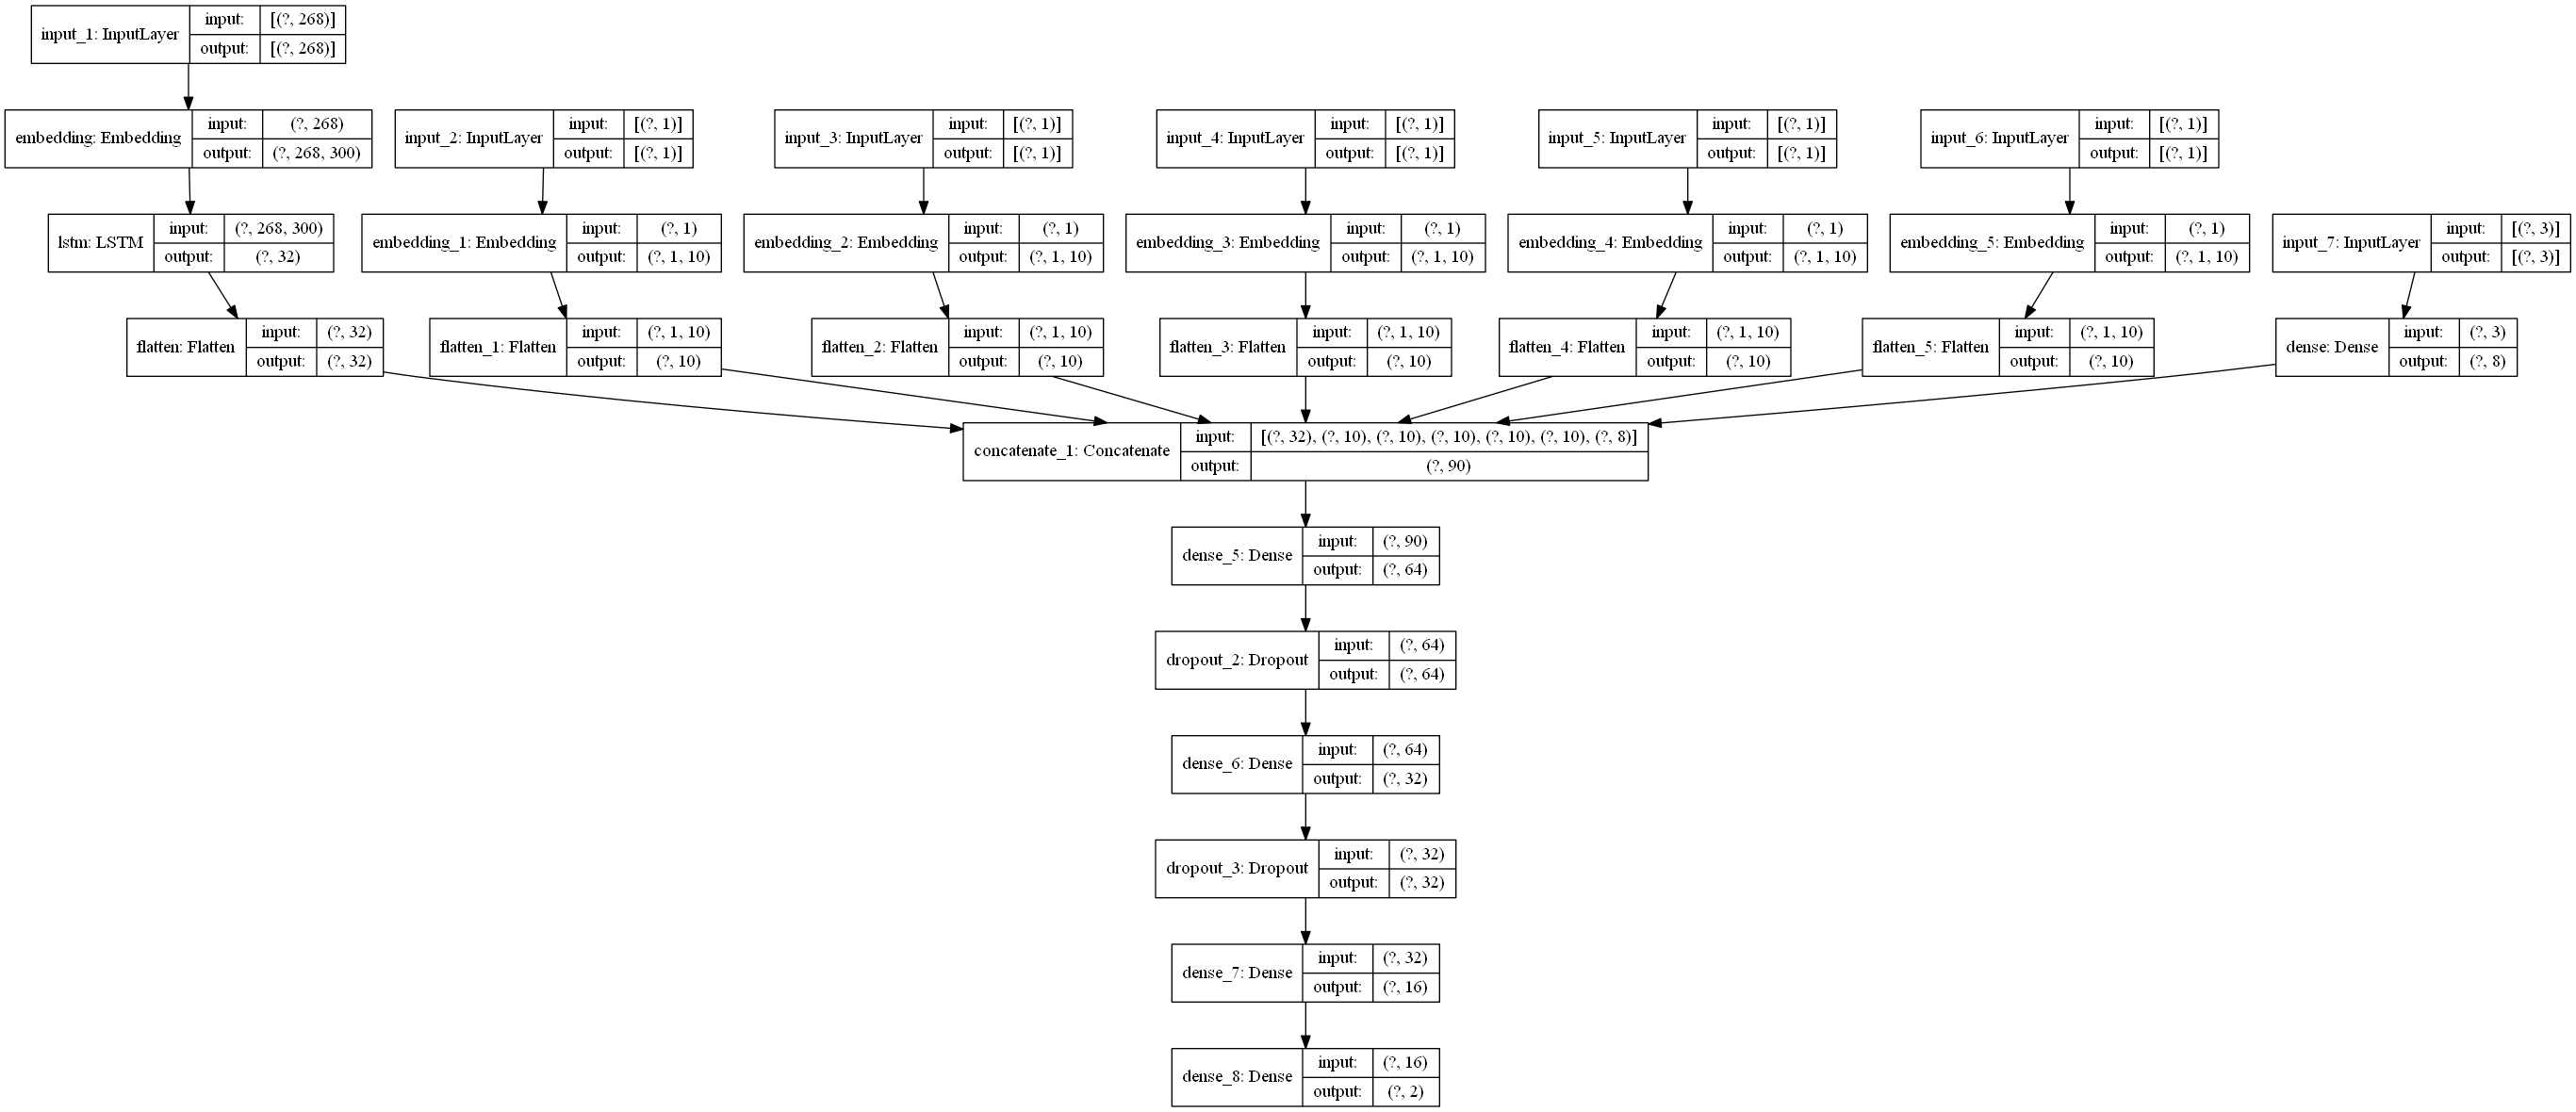

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model1, 'model1.png', show_shapes=True)

In [24]:
from sklearn.metrics import roc_auc_score
import tensorflow
def auroc(y_true, y_pred):
    return tensorflow.py_function(roc_auc_score, (y_true, y_pred), tensorflow.double)

In [25]:
model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=[auroc],
              )

In [26]:
log_dir="log\model1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [tensorboard_callback]

model1.fit([train_padded, *X_train_enc, X_train[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()],
           y_train,
           batch_size=512,
           epochs=5,
           verbose=1,
           validation_data=([test_padded, *X_test_enc, X_test[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()], y_test),
           callbacks=callbacks_list,
          )

AttributeError: 'DataFrame' object has no attribute 'to_numpy'

In [34]:
test_data = [test_padded, *X_test_enc, X_test[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()]
y_true = y_test

y_pred = model1.predict(test_data)

auc = auroc(y_true, y_pred)
print('test auc = {} %'.format(float(auc)*100))

test auc = 83.67935189538174 %


In [ ]:
# tf.keras.backend.clear_session()
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir 'log\model1'

# Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train['text'])

<85398x53462 sparse matrix of type '<class 'numpy.float64'>'
	with 12071852 stored elements in Compressed Sparse Row format>

In [36]:
len(vectorizer.idf_)

53462

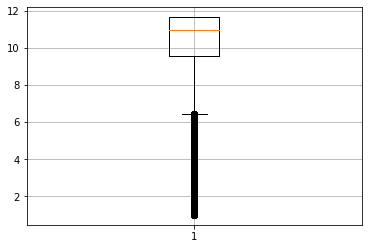

In [37]:
import matplotlib.pyplot as plt
plt.grid()
plt.boxplot(vectorizer.idf_);
plt.title('Box plot of idf of words:');

In [38]:
Q1 = np.percentile(vectorizer.idf_, 25)
Q3 = np.percentile(vectorizer.idf_, 75)

print('Q1:', Q1)
print('Q3:', Q3)

Q1: 9.582500947866448
Q3: 11.661942489546284


### Remove the low idf value and high idf value words from our data

In [39]:
low_and_high_idf_words = [i for i,j in zip(vectorizer.get_feature_names(), list(vectorizer.idf_)) if j<Q1 or j>Q3]

In [40]:
len(low_and_high_idf_words)
# print(low_and_high_idf_words)

13048

In [42]:
pattern = re.compile('|'.join(low_and_high_idf_words))

# removing words with low and high idf
X_train['text'] = X_train['text'].apply(lambda x: re.sub(pattern, '', x))

# replacing more space with single space
X_train['text'] = X_train['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [43]:
X_test['text'] = X_test['text'].apply(lambda x: re.sub(pattern, '', x))
# replacing more space with single space
X_test['text'] = X_test['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

C:\Users\Nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Nehal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
X_cv['text'] = X_cv['text'].apply(lambda x: re.sub(pattern, '', x))
# replacing more space with single space
X_cv['text'] = X_cv['text'].apply(lambda x: re.sub(r'\s+', ' ', x))

### Converting text data (essay, project_title) to Numerical data by text_to_sequence and then padding and then embedding

In [45]:
# Tokenize our training data
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(X_train['text'])

# Get our training data word index
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
print('vocab size:', vocab_size)
# print('word index: ', word_index)

vocab size: 25676


In [46]:
# Encode train, test and cv data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train['text'])
test_sequences = tokenizer.texts_to_sequences(X_test['text'])
cv_sequences = tokenizer.texts_to_sequences(X_cv['text'])

# Get max training sequence length
maxlen = int(np.mean([len(x) for x in train_sequences]))

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
cv_padded = pad_sequences(cv_sequences, padding='post', truncating='post', maxlen=maxlen)

print('maxlen: ', maxlen)
print("\nPadded train shape:", train_padded.shape)
print("Padded test shape:", test_padded.shape)
print("Padded cv shape:", cv_padded.shape)

print("\nTraining sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))

maxlen:  155

Padded train shape: (85398, 155)
Padded test shape: (28454, 155)
Padded cv shape: (28449, 155)

Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [47]:
with open(r'C:\Users\Nehal\AppliedAICourse\datas\glove_vectors', 'rb') as f:
    glove_vectors = pickle.load(f)


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('embedding matrix shape: ', embedding_matrix.shape)

embedding matrix shape:  (25676, 300)


In [48]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.2702134288830036

### Layer 1 (text data)

In [49]:
# 1
input_seq_total_text_data = Input(shape=(maxlen,))

embd_layer1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen)(input_seq_total_text_data)

lstm = LSTM(32)(embd_layer1)

flatten1 = Flatten()(lstm)

### Merging all the Input Layers

In [50]:
input_layer = [input_seq_total_text_data, *in_layers, input_layer7]
# input_layer = [input_seq_total_text_data, input_layer6]

merge = Concatenate()([flatten1,*flatten_layers, dense7])

dense1 = Dense(units=64, activation='relu')(merge)
dropout1 = Dropout(0.2)(dense1)

dense2 = Dense(units=32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense2)

dense3 = Dense(units=16, activation='relu')(dropout2)

output_layer = Dense(units=2, activation='softmax')(dense3)

model2 = Model(input_layer, output_layer)

# model1.summary()

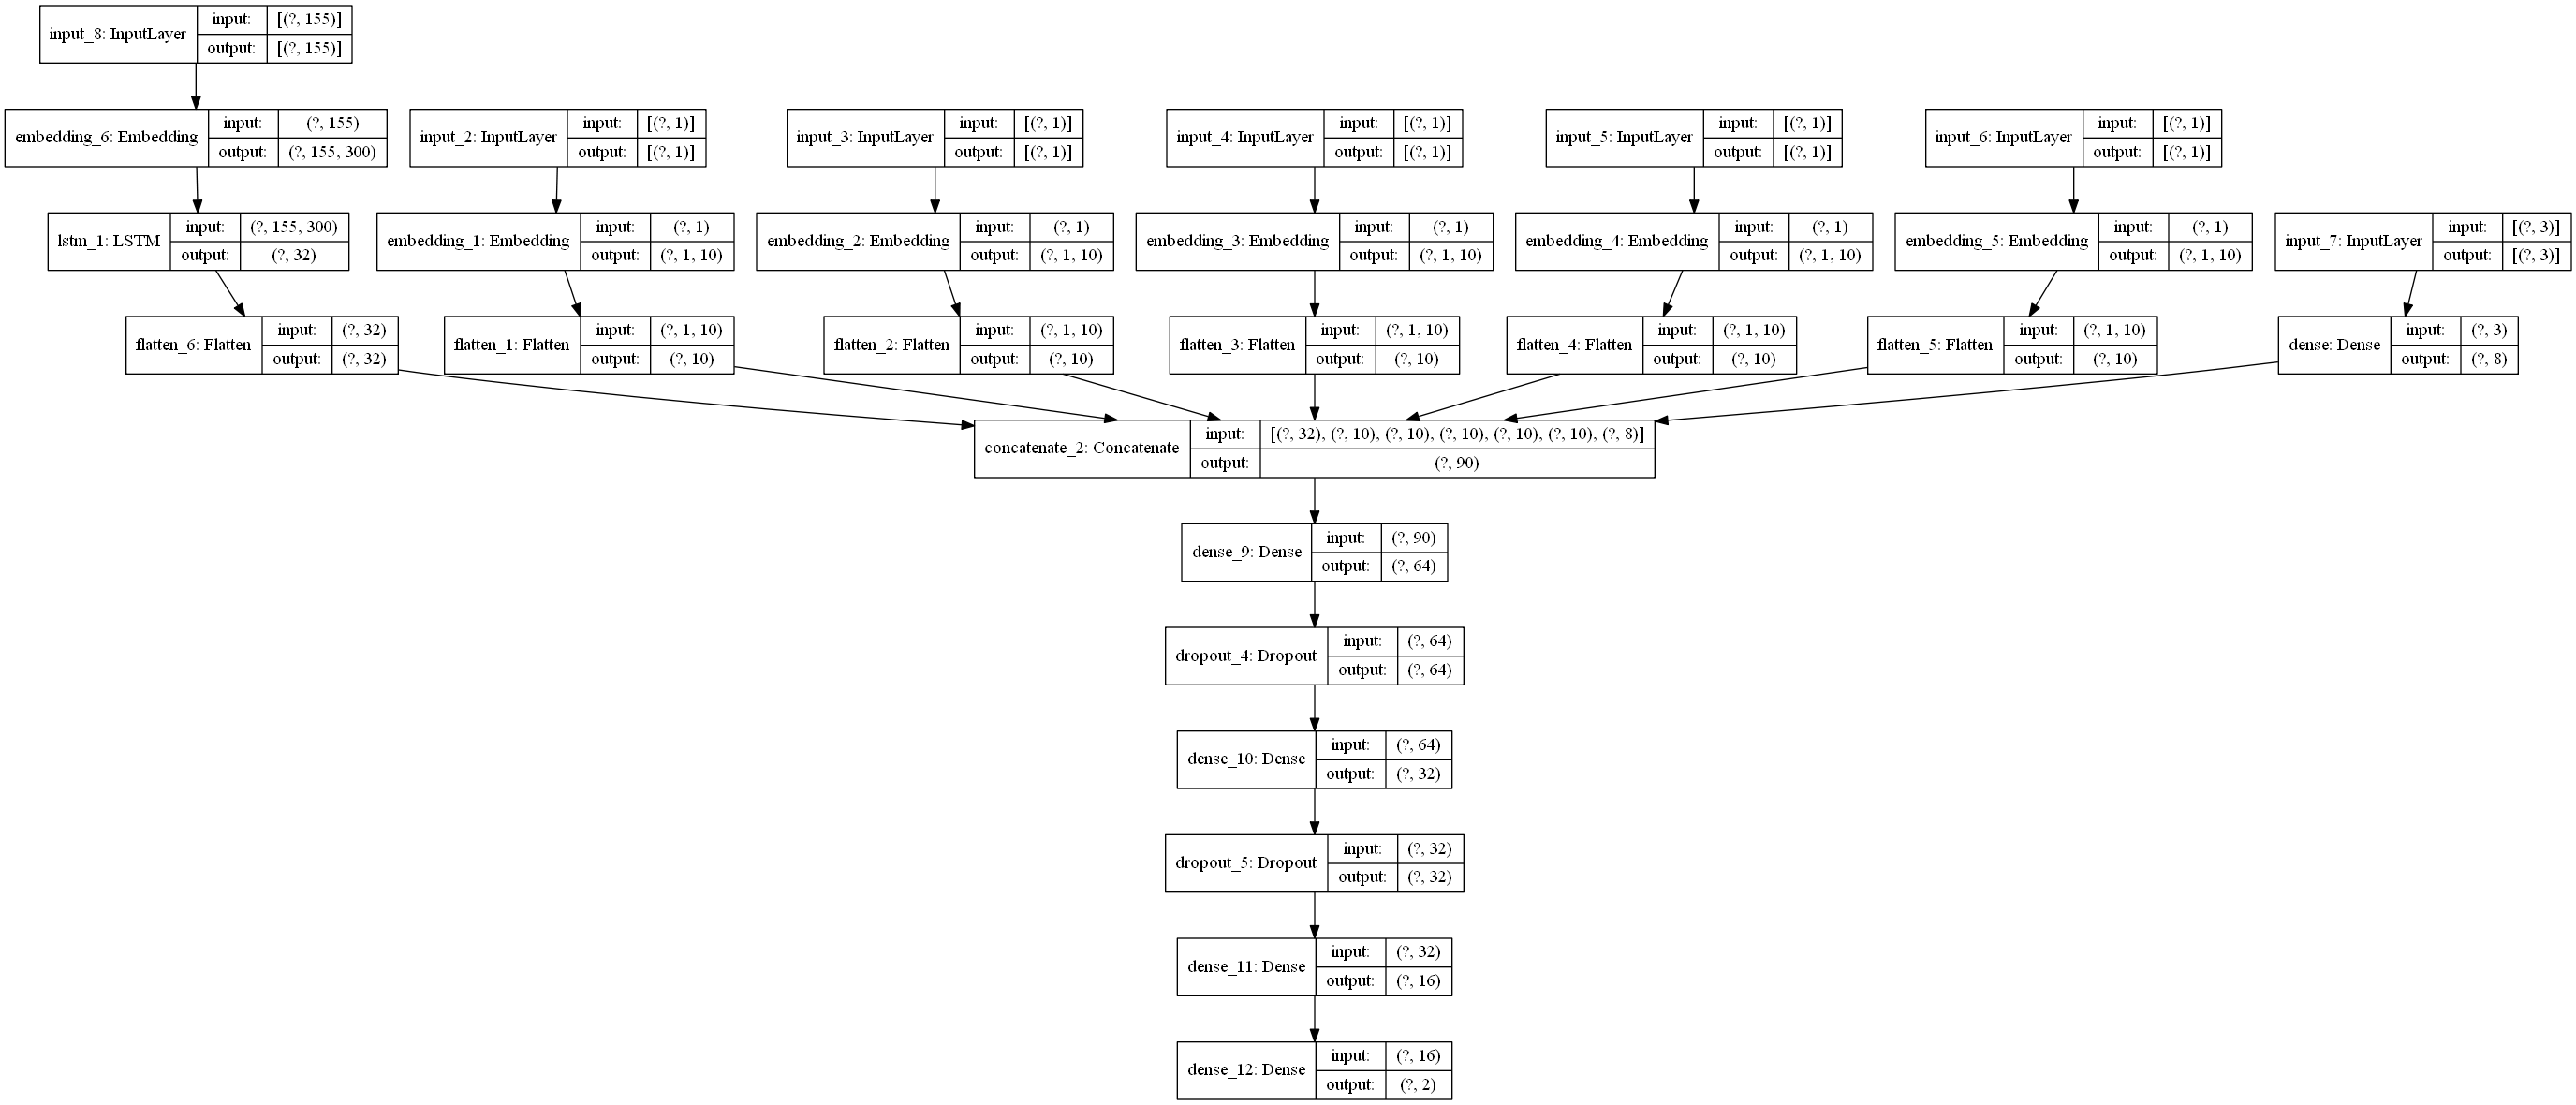

In [51]:
from tensorflow.keras.utils import plot_model

plot_model(model2, 'model2.png', show_shapes=True)

In [52]:
from sklearn.metrics import roc_auc_score
import tensorflow
def auroc(y_true, y_pred):
    return tensorflow.py_function(roc_auc_score, (y_true, y_pred), tensorflow.double)

In [53]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=[auroc],
               )

In [54]:
log_dir="log\model2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [tensorboard_callback]

model2.fit([train_padded, *X_train_enc, X_train[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()],
           y_train,
           batch_size=512,
           epochs=5,
           verbose=1,
           validation_data=([test_padded, *X_test_enc, X_test[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()], y_test),
           callbacks=callbacks_list,
          )

Train on 85398 samples, validate on 28454 samples
Epoch 1/5
85398/85398 [==============================] - 92s 1ms/sample - loss: 0.6229 - auroc: 0.6295 - val_loss: 0.6120 - val_auroc: 0.6617
Epoch 2/5
85398/85398 [==============================] - 81s 945us/sample - loss: 0.5979 - auroc: 0.6848 - val_loss: 0.5908 - val_auroc: 0.7021
Epoch 3/5
85398/85398 [==============================] - 80s 939us/sample - loss: 0.5653 - auroc: 0.7348 - val_loss: 0.5737 - val_auroc: 0.7277
Epoch 4/5
85398/85398 [==============================] - 83s 977us/sample - loss: 0.5354 - auroc: 0.7721 - val_loss: 0.5683 - val_auroc: 0.7396
Epoch 5/5
85398/85398 [==============================] - 83s 970us/sample - loss: 0.5116 - auroc: 0.7981 - val_loss: 0.5554 - val_auroc: 0.7537


In [55]:
test_data = [test_padded, *X_test_enc, X_test[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()]
y_true = y_test

y_pred = model2.predict(test_data)

auc = auroc(y_true, y_pred)
print('model 2 test auc = {} %'.format(float(auc)*100))

model 2 test auc = 75.35027980276318 %


In [ ]:
# tf.keras.backend.clear_session()
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir 'log\model2'

# Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
train_school_state_oht = cv.fit_transform(X_train['school_state'])
test_school_state_oht = cv.transform(X_test['school_state'])
cv_school_state_oht = cv.transform(X_cv['school_state'])

train_teacher_prefix_oht = cv.fit_transform(X_train['teacher_prefix'])
test_teacher_prefix_oht = cv.transform(X_test['teacher_prefix'])
cv_teacher_prefix_oht = cv.transform(X_cv['teacher_prefix'])

train_project_grade_category_oht = cv.fit_transform(X_train['project_grade_category'])
test_project_grade_category_oht = cv.transform(X_test['project_grade_category'])
cv_project_grade_category_oht = cv.transform(X_cv['project_grade_category'])

train_project_subject_categories_oht = cv.fit_transform(X_train['project_subject_categories'])
test_project_subject_categories_oht = cv.transform(X_test['project_subject_categories'])
cv_project_subject_categories_oht = cv.transform(X_cv['project_subject_categories'])

In [57]:
train_numerical = np.concatenate((train_school_state_oht.toarray(),
                                  train_teacher_prefix_oht.toarray(),
                                  train_project_grade_category_oht.toarray(),
                                  train_project_subject_categories_oht.toarray(),
                                  X_train[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()
                                  ),
                                 axis=1)

train_numerical = train_numerical.reshape(list(train_numerical.shape)+[1])
train_numerical.shape

(85398, 113, 1)

In [58]:
test_numerical = np.concatenate((test_school_state_oht.toarray(),
                                  test_teacher_prefix_oht.toarray(),
                                  test_project_grade_category_oht.toarray(),
                                  test_project_subject_categories_oht.toarray(),
                                  X_test[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()
                                  ),
                                 axis=1)

test_numerical = test_numerical.reshape(list(test_numerical.shape)+[1])
test_numerical.shape

(28454, 113, 1)

In [59]:
cv_numerical = np.concatenate((cv_school_state_oht.toarray(),
                                  cv_teacher_prefix_oht.toarray(),
                                  cv_project_grade_category_oht.toarray(),
                                  cv_project_subject_categories_oht.toarray(),
                                  X_cv[['nrm_teacher_number_of_previously_posted_projects','nrm_quantity','nrm_price']].to_numpy()
                                  ),
                                 axis=1)

cv_numerical = cv_numerical.reshape(list(cv_numerical.shape)+[1])
cv_numerical.shape

(28449, 113, 1)

In [60]:
train_numerical.shape[1:]

(113, 1)

In [61]:
input_layer_numerical = Input(shape=(train_numerical.shape[1:]), name='Input_Layer_numerical')

c1d1 = Conv1D(filters=64, kernel_size=7, strides=5, activation='relu', name='conv1')(input_layer_numerical)
c1d2 = Conv1D(filters=32, kernel_size=5, strides=3, activation='relu', name='conv2')(c1d1)
c1d3 = Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', name='conv3')(c1d2)

flat_numerical = Flatten()(c1d3)

In [62]:
input_layer = [input_seq_total_text_data, input_layer_numerical]

merge = Concatenate()([flatten1, flat_numerical])

dense1 = Dense(units=64, activation='relu')(merge)
dropout1 = Dropout(0.2)(dense1)

dense2 = Dense(units=32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense2)

dense3 = Dense(units=16, activation='relu')(dropout2)

output_layer = Dense(units=2, activation='softmax')(dense3)

model3 = Model(input_layer, output_layer)

model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer_numerical (InputLay [(None, 113, 1)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 155)]        0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 22, 64)       512         Input_Layer_numerical[0][0]      
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 155, 300)     7702800     input_8[0][0]                    
____________________________________________________________________________________________

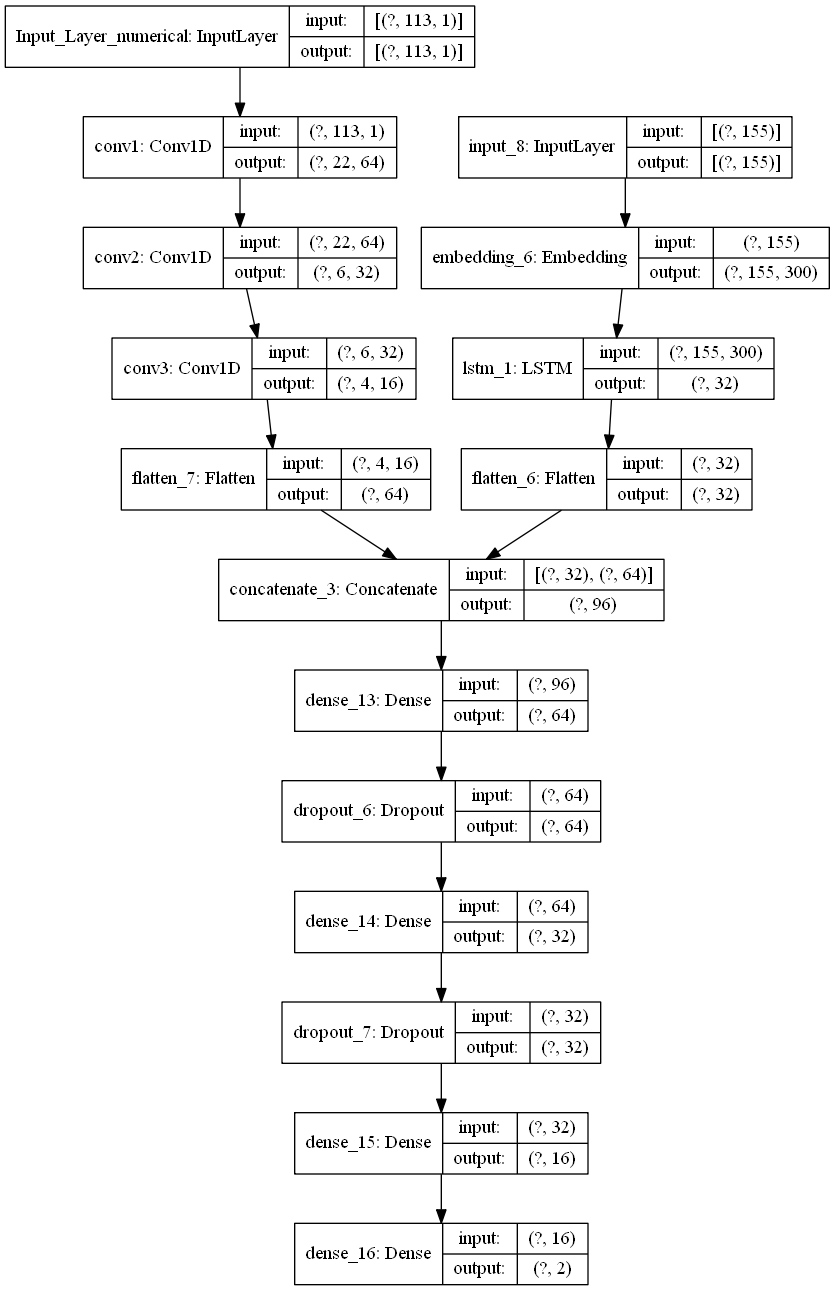

In [63]:
from tensorflow.keras.utils import plot_model

plot_model(model3, 'model3.png', show_shapes=True)

In [64]:
from sklearn.metrics import roc_auc_score
import tensorflow
def auroc(y_true, y_pred):
    return tensorflow.py_function(roc_auc_score, (y_true, y_pred), tensorflow.double)

In [65]:
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=[auroc],
               )

In [66]:
log_dir="log\model3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [tensorboard_callback]

model3.fit([train_padded, train_numerical],
           y_train,
           batch_size=512,
           epochs=5,
           verbose=1,
           validation_data=([cv_padded, cv_numerical], y_cv),
           callbacks=callbacks_list,
          )

Train on 85398 samples, validate on 28449 samples
Epoch 1/5
85398/85398 [==============================] - 91s 1ms/sample - loss: 0.5262 - auroc: 0.7809 - val_loss: 0.5827 - val_auroc: 0.7276
Epoch 2/5
85398/85398 [==============================] - 85s 996us/sample - loss: 0.4960 - auroc: 0.8129 - val_loss: 0.5813 - val_auroc: 0.7392
Epoch 3/5
85398/85398 [==============================] - 85s 994us/sample - loss: 0.4785 - auroc: 0.8280 - val_loss: 0.5637 - val_auroc: 0.7472
Epoch 4/5
85398/85398 [==============================] - 85s 996us/sample - loss: 0.4634 - auroc: 0.8410 - val_loss: 0.5755 - val_auroc: 0.7524
Epoch 5/5
85398/85398 [==============================] - 87s 1ms/sample - loss: 0.4515 - auroc: 0.8500 - val_loss: 0.5556 - val_auroc: 0.7580


In [67]:
test_data = [test_padded, test_numerical]
y_true = y_test

y_pred = model3.predict(test_data)

auc = auroc(y_true, y_pred)
print('Model 3 test auc = {} %'.format(float(auc)*100))

Model 3 test auc = 76.07821265561847 %


In [ ]:
# tf.keras.backend.clear_session()
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir 'log\model2'